# 한국어 데이터로 챗봇 만들기
## 목차
1. 데이터 수집하기
2. 데이터 전처리 하기
3. SubwordTextEncoder 사용하기
4. 모델 구성하기
5. 모델 훈련하기
6. 모델 평가하기

# 1. 데이터 수집하기

In [1]:
import pandas as pd
import os


# 학습 데이터 불러오기
data_dir = os.getenv('HOME') + '/aiffel/transformer_chatbot/data/'
data = pd.read_csv(data_dir + 'ChatbotData .csv')

# 데이터 확인하기
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [2]:
# 데이터 열 정보 확인하기
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB


# 2. 데이터 전처리하기
- 문장부호에 띄어쓰기 추가
    - 문장부호와 단어를 별개의 단어로 취급하기
- 문장 양 옆의 공백 지우기

In [3]:
# 결측치 확인하기
data.isnull().sum()

Q        0
A        0
label    0
dtype: int64

In [4]:
# 샘플 개수 제한
MAX_SAMPLES = 50000
print(MAX_SAMPLES)

50000


In [5]:
import re

def preprocess_sentence(sentence):
    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    # 두 글자 이상의 긴 공백을 한 글자로 줄여주기
    sentence = re.sub(r'[" "]+', " ", sentence)

    sentence = sentence.strip()
    return sentence

In [6]:
# 원본 파일에서 전처리된 샘플 데이터와 타겟 데이터 가져오기
def load_conversations():
    inputs, outputs = [], []

    for _, row in data.iterrows():
            # 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용.
            inputs.append(preprocess_sentence(row['Q']))
            outputs.append(preprocess_sentence(row['A']))

            if len(inputs) >= MAX_SAMPLES:
                return inputs, outputs
    
    return inputs, outputs

In [7]:
# 전처리된 데이터 개수 확인하기
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [8]:
# 전처리 결과 확인하기
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요 .


# 3. SubwordTextEncoder 사용하기
- 본래 한국어에서 사용해야하는 형태소 분석기 대신 사용
- 한 문장을 의미를 가진 더 작은 단위(어근, 접두사, 접미사 등)로 나누기
    - 학습 데이터셋에 없는 단어의 의미도 어느정도 파악할 수 있게됨

In [9]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [10]:
# Vocabulary에 시작 토큰과 종료 토큰 추가하기
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [11]:
# 추가 토큰과 종료 토큰의 정수값 확인하기
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8173]
END_TOKEN의 번호 : [8174]


In [12]:
# 단어 개수
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8175


In [13]:
# 정수 인코딩 결과 확인하기
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5764, 610, 2492, 4164]
정수 인코딩 후의 21번째 답변 샘플: [2356, 7513, 7, 6276, 97, 1]


In [14]:
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [15]:
import tensorflow as tf

# 정수 인코딩과 패딩처리
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
  
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
  
    # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
    return tokenized_inputs, tokenized_outputs

In [16]:
# 토크나이징과 패딩후 변화된 샘플 개수 확인하기
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8175
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


In [17]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

# 데이터셋 만들기
dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE) # 데이터 순서를 섞을 때 사용할 버퍼 크기
dataset = dataset.batch(BATCH_SIZE) # mini-batch 만들기
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

# 4. 모델 구성하기
## Transformer 전체 구조
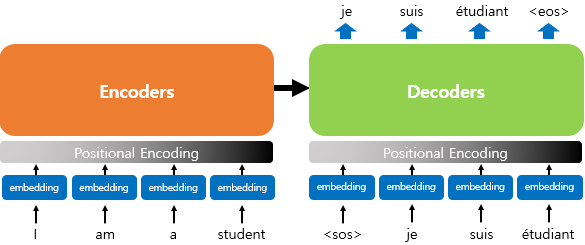
- Positional Encoding
    - 입력 시퀀스에 위치 정보를 추가함
- Encoders
    - 입력 시퀀스의 내용을 해석함
    - RNN과는 다르게 한 시퀀스 통째로 가져가서 해석함
- Decoders
    - Encoders가 해석한 내용을 바탕으로 새로운 시퀀스를 생성함
    - RNN과는 다르게 한 시퀀스 통째로 생성함

## Positional Encoding
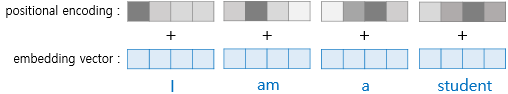
- 임베딩 벡터에 위치 정보를 더해준다
    - (len_sequence, d_model) 크기의 시퀀스 행렬에 같은 크기의 포지셔널 행렬을 더해준다
        - len_sequence: 시퀀스 길이
        - d_model: 임베딩 벡터의 크기
        

### Positional Encoding 값 계산
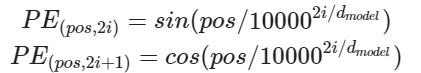
- pos: 시퀀스 내 단어 위치
- i: 임베딩 벡터 내 요소 위치

In [18]:
import tensorflow as tf

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        '''
        __init__
        파라미터:
            position: 시퀀스 최대 길이
            d_model: 임베딩 벡터 크기
        '''
        super(PositionalEncoding, self).__init__()
        # 레이어가 생성되지마자 포지셔널 행렬 만들기
        self.pos_encoding = self.positional_encoding(position, d_model)
    
    # get_angles
    def get_angles(self, position, i, d_model):
        '''
        get_angles
        파라미터:
            position, i: 계산하려는 포지셔널 행렬 요소의 좌표값
            d_model: 임베딩 벡터 크기
        반환값:
            포지셔널 행렬의 값을 계산할 때 sin, cos에 들어가는 각도값
        '''
        # 분모값 먼저 계산
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, dtype=tf.float32))
        
        return position * angles
    
    def positional_encoding(self, position, d_model):
        '''
        positional_encoding
        파라미터:
            position: 시퀀스 최대 길이
            d_model: 임베딩 벡터 크기
        반환값:
            (1, position, d_model) 크기의 포지셔널 행렬
        '''
        angle_rads = self.get_angles( # position과 i를 2d 텐서로 넘겨서 포지셔닝 행렬을 한번에 만듦
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis], # (position, 1), range(position) 텐서화
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :], # (1, d_model), range(d_model).T 텐서화
            d_model=d_model
        )
        
        # 짝수열과 홀수열을 따로 떼내서 각각 sin, cos 함수 계산
        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])
        
        # 열을 분리해서 계산한 값을 원래 모습으로 조립
        pos_encoding = tf.stack([sines, cosines], axis=0)            # (2, position, d_model // 2) 크기로 병합
        pos_encoding = tf.transpose(pos_encoding, [1, 2, 0])         # (position, d_model // 2, 2) 크기로 변환
        pos_encoding = tf.reshape(pos_encoding, [position, d_model]) # (position, d_model) 크기로 변환
        
        pos_encoding = pos_encoding[tf.newaxis, ...] # (1, position, d_model) 크기로 차원 확장
        return tf.cast(pos_encoding, dtype=tf.float32)
    
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

### 포지셔닝 행렬 시각화

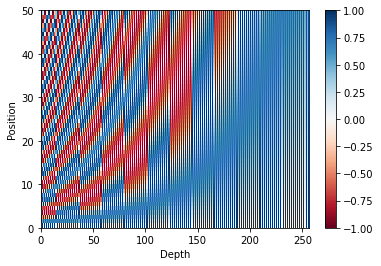

In [19]:
import matplotlib.pyplot as plt


sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 256))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Encoder
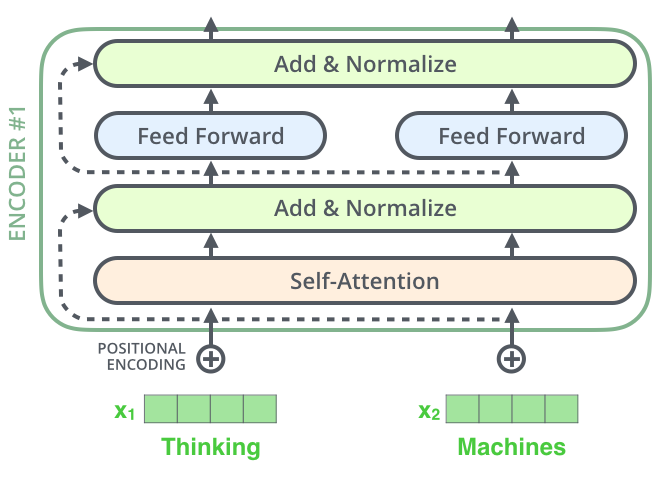
- Self-Attention
    - Scaled Dot-product Attention
- Add & Normalize
    - 정보 손실을 줄이기 위해 skip connection 적용
- Feed Forward

### Scaled Dot-product Attention
$$
Attention(Q,K,V)=softmax(\frac{QK^T}{\sqrt{d_k}})V
$$
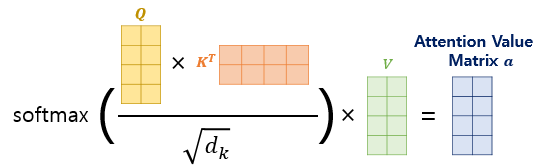
- 어텐션 가중치 계산을 Query와 Key의 행렬 곱셈으로 구하는 어텐션 메커니즘
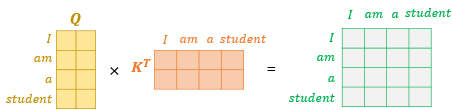
- 임베딩 벡터가 커질수록 어텐션 스코어가 커지기 때문에 임베딩 벡터 크기로 정규화

In [20]:
def scaled_dot_product_attention(query, key, value, mask):
    '''
    scaled_dot_preduct_attention
    파라미터:
        query: (batch_size, num_heads, position, depth) d_model = depth * num_heads
        key: (batch_size, num_heads, position, depth)
        value: (batch_size, num_heads, position, depth)
        mask: (batch_size, 1, None, position) or None
    '''
    # 어텐션 스코어 행렬
    matmul_qk = tf.matmul(query, key, transpose_b=True)
    
    # 임베딩 벡터 크기로 정규화
    depth = tf.cast(tf.shape(key)[-1], dtype=tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)
    
    if mask is not None:
        logits += (mask * -1e9)
    
    # softmax로 어텐션 스코어를 어텐션 가중치로 변환
    attention_weights = tf.nn.softmax(logits, axis=-1)
    
    # 어텐션 가중치를 Value에 반영
    output = tf.matmul(attention_weights, value)
    return output

### Multi-head Attention
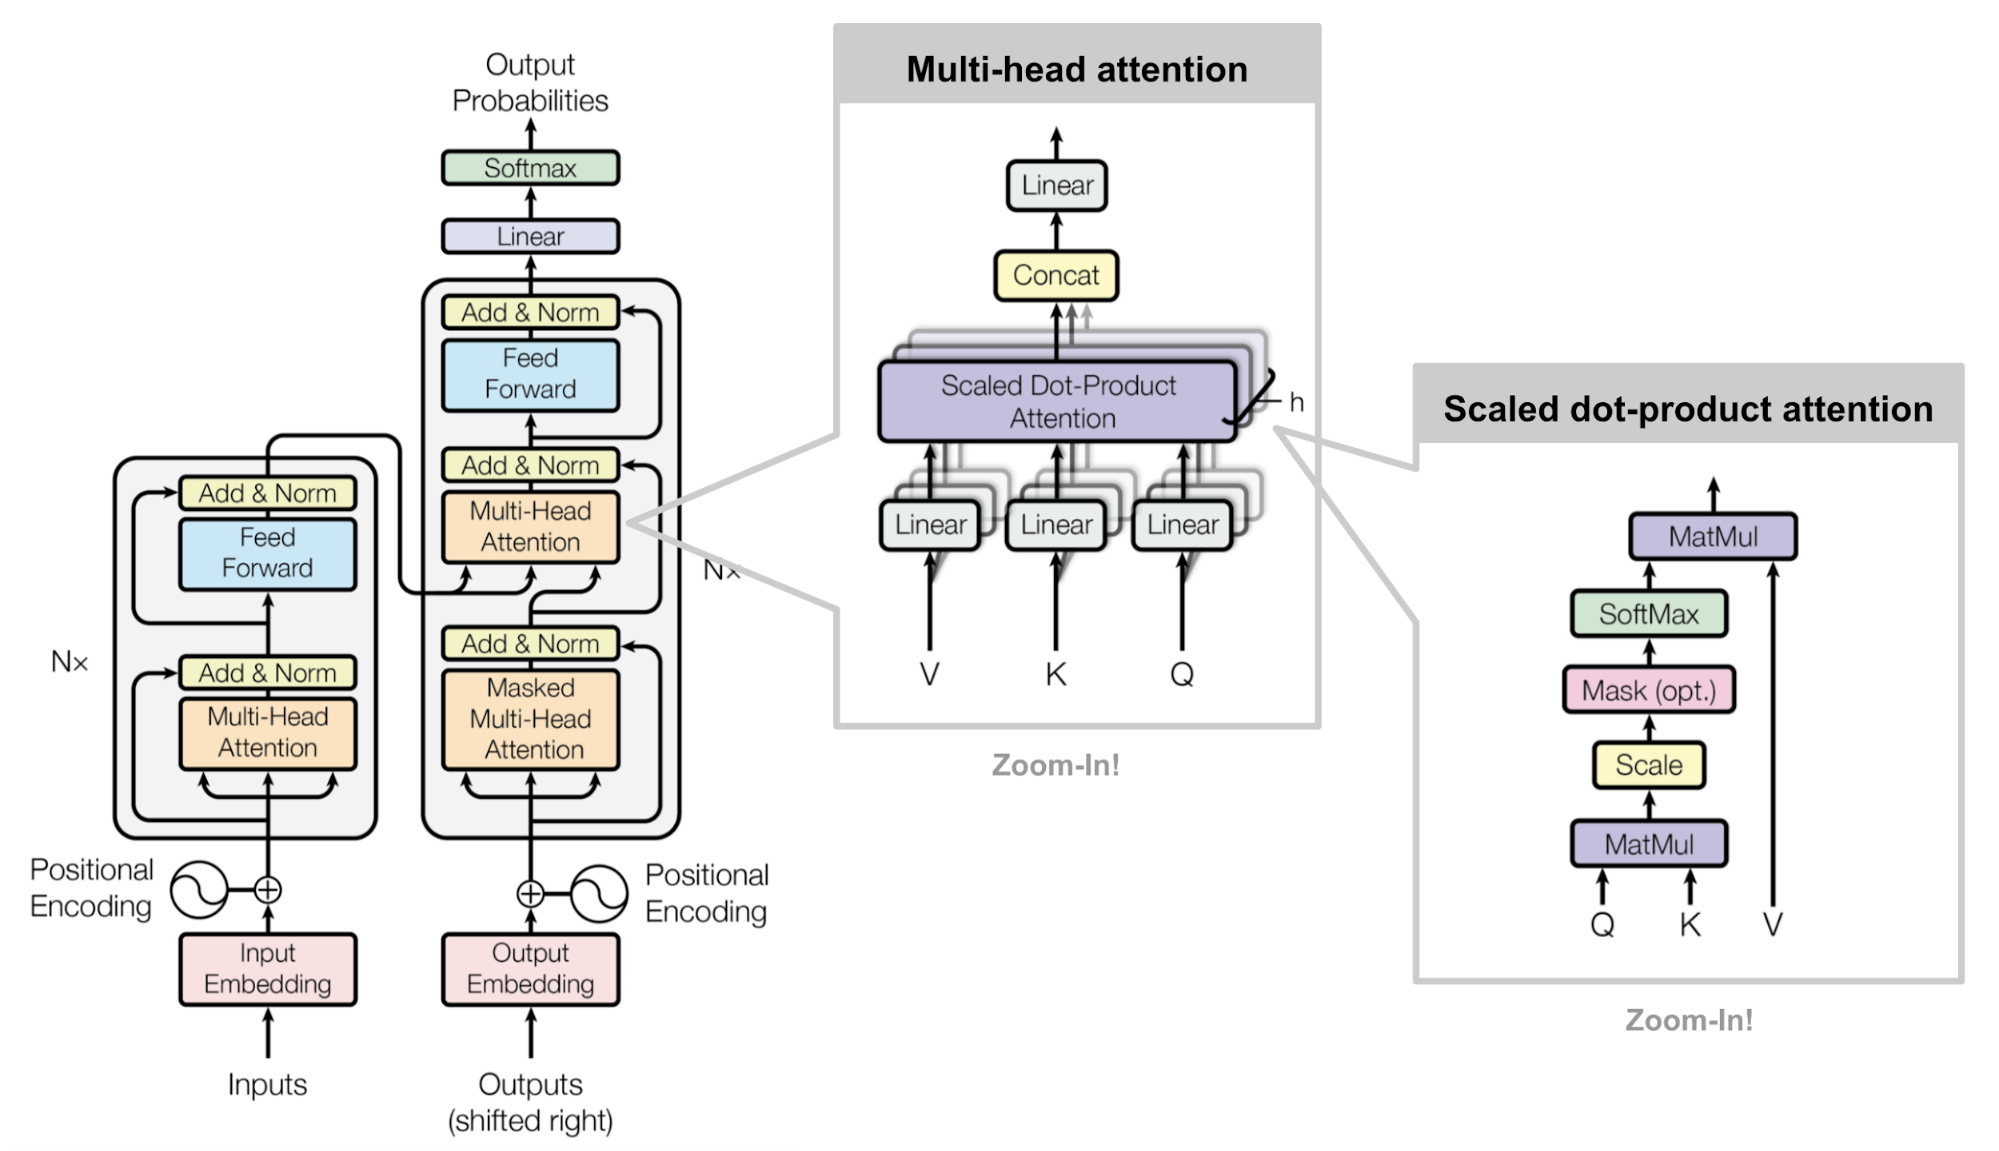
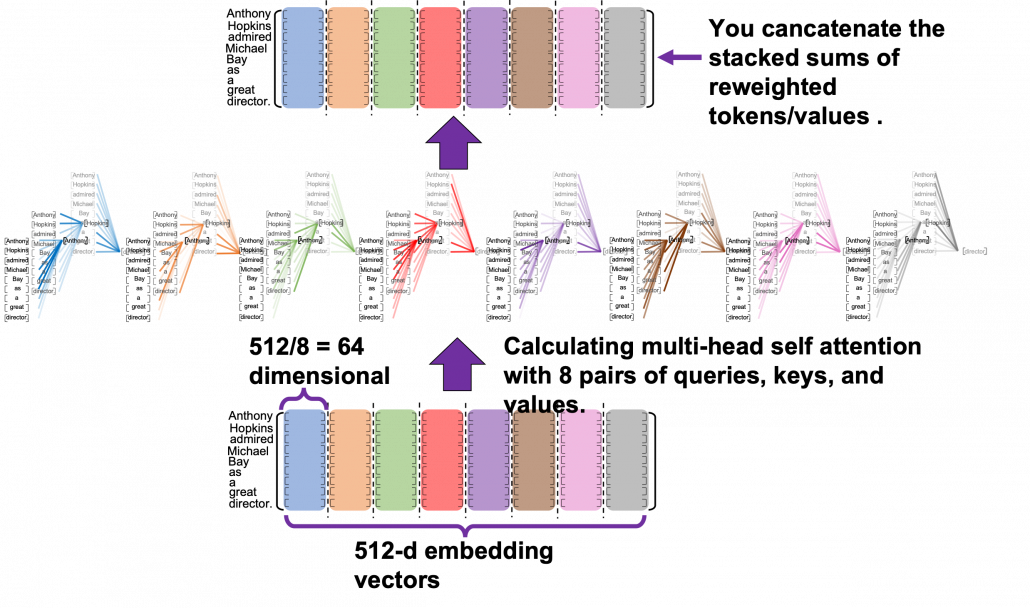
- 임베딩 벡터를 나눠서 각자 Attention 구하기
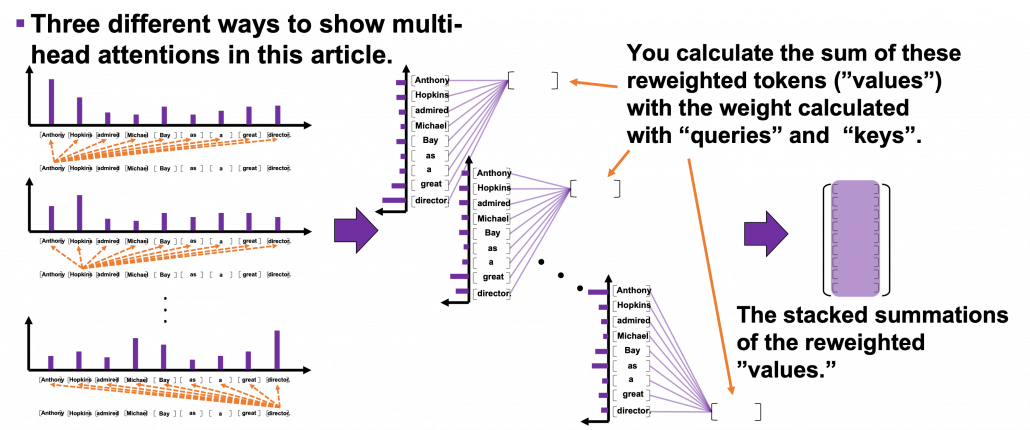
- 각 head마다 단어끼리의 유사도를 파악하는 관점을 달리하여 좀더 풍부한 의미를 파악할 수 있다

In [21]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        
        self.num_heads = num_heads
        self.d_model = d_model
        
        # depth: 헤드 하나당 나눠진 임베딩 벡터의 크기
        # 나누어 떨어지지 않으면 어텐션 레이어 생성을 막아야함
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        
        # 토큰 하나에서 Query, Key, Value를 뽑아내기
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)
        
        # 멀테 헤드 어텐션을 지난 후 한번더 Dense에 통과
        self.dense = tf.keras.layers.Dense(units=d_model)
        
    def split_heads(self, inputs, batch_size):
        '''
        split_heads
        파라미터:
            inputs: (batch_size, position, d_model), 시퀀스 행렬
            batch_size: 시퀀스 길이
        반환값:
            (batch_size, num_heads, position, depth), num_heads만큼 분리된 행렬
        '''
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth)
        )
        return tf.transpose(inputs, perm=[0, 2, 1, 3])
    
    def call(self, inputs):
        '''
        call
        파라미터:
            inputs: Dict{
                'query': (batch_size, pos, d_model)
                'key': (batch_size, pos, d_model)
                'value': (batch_size, pos, d_model)
                'mask': (batch_size, 1, None, d_model) or None, 어텐션 스코어 행렬에 적용할 마스크
            }
        반환값:
            멀티 헤드 어텐션 연산을 한 시퀀스 행렬
        '''
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # 들어온 값에서 Query, Key, Value를 구하기
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        # 멀티 헤드 어텐션을 하고난 후 다시 원상복귀
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

### 마스킹
- 패딩 마스크
- 룩 어헤드 마스크
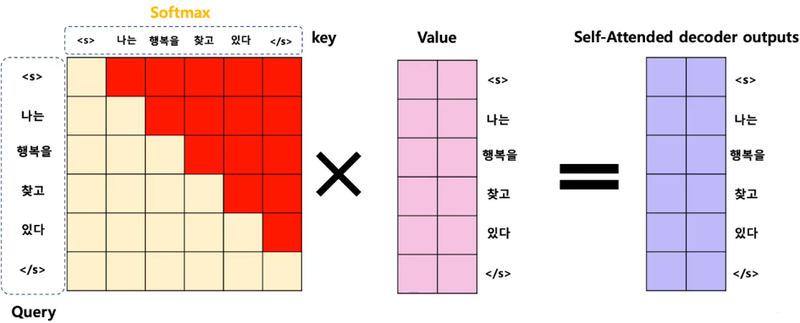

In [22]:
def create_padding_mask(x):
    '''
    create_padding_mask
    파라미터:
        x: (pos, d_model), 시퀀스 행렬
    반환값:
        (pos, 1, 1, d_model), 0 패딩 부분은 1, 값이 있던 부분은 0
    '''
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    return mask[:, tf.newaxis, tf.newaxis, :]

# 패딩 마스크 테스트
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))
print(create_padding_mask(tf.constant([[0, 5, 1, 5, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)
tf.Tensor([[[[1. 0. 0. 0. 0.]]]], shape=(1, 1, 1, 5), dtype=float32)


In [23]:
def create_look_ahead_mask(x):
    '''
    create_look_ahead_mask
    파라미터:
        x: (batch_size, pos, d_model), 시퀀스 행렬
    반환값:
        (batch_size, 1, d_model, d_model), 어텐션 스코어 행렬에 적용할 마스크
    '''
    # 시퀀스 길이
    seq_len = tf.shape(x)[1]
    
    # look_ahead_mask
    # 0 1 1 1
    # 0 0 1 1
    # 0 0 0 1
    # 0 0 0 0
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    
    # 패딩 마스크 먼저 구하기
    padding_mask = create_padding_mask(x)
    # 패딩 마스크와 룩 어헤드 마스크를 겹치기
    return tf.maximum(look_ahead_mask, padding_mask)

# 룩 어헤드 마스크 테스트
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)
tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]
   [1. 1. 1. 0. 1.]
   [1. 1. 1. 0. 0.]]]], shape=(2, 1, 5, 5), dtype=float32)


### 인코더 블록

In [24]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    '''
    encoder_layer
    파라미터:
        units: 완전 연결층의 유닛 수
        d_model: 임베딩 벡터의 크기
        num_heads: 멀티 헤드 어텐션의 헤드 수
        dropout: 드롭아웃 확률
        name: 레이어에 붙일 이름
    반환값:
        인코더 블록
    '''
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # Self-Attention
    # Query, Key, Value는 inputs에서 도출
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
        })

    
    # Add & Normalization
    # 셀프 어텐션의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention) # skip-connection

    # Feed Forward
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # Add & Normalization
    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs) # skip-connection

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [25]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

## Decoder
![](https://d3s0tskafalll9.cloudfront.net/media/images/Untitled_3_ddZedfW.max-800x600.png)

In [26]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # Self-Attention
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
        })
    
    # Add & Normalize
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

    # Encoder-Decoder Attention
    attention2 = MultiHeadAttention(
    d_model, num_heads, name="attention_2")(inputs={
        'query': attention1,  # Decoder의 다음 단어를 찾아야 하기에 연관성 기준을 Decoder 값으로 지정
        'key': enc_outputs,   # 찾아야하는 정보는 Encoder가 처리한 데이터에 있으니 key와 value 모두 Encoder 값으로 지정
        'value': enc_outputs,
        'mask': padding_mask
    })
    
    # Add & Normalize
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)

    # Feed Forward
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # Add & Normalize
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

In [27]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    # 인코더의 최종 결과물
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    # encoder-decoder attention에 건내줄 인코더의 중간 결과물
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    
    # 룩 어헤드 마스크
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')
    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # 원하는 개수만큼 디코더 레이어를 쌓기
    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

## Transformer 모델
![](https://d3s0tskafalll9.cloudfront.net/media/images/Untitled_2_EnQyi4S.max-800x600.png)

In [28]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    # 인코더 학습용 입력 데이터
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    # 디코더 학습용 입력 데이터
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

# 5. 모델 훈련
- 손실 함수
    - Sparse Categorical Cross Entropy
    - 패딩 마스크 적용
        - 패딩값이 loss값에 영향을 주지 않기 위함
- 학습률
$$
learning\_rate = d^{-0.5}_{model}\cdot \min(step\_num^{-0.5}, step\_num\cdot warmup\_steps^{-1.5})
$$

In [29]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3147008     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [30]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    # 손실 함수: 실제 문장에 나온 다음 단어와 일치하는지 계산
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    # 패딩 마스크로 패딩이 주는 영향 없애기
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

In [31]:
# 커스텀 학습률 스케쥴러
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

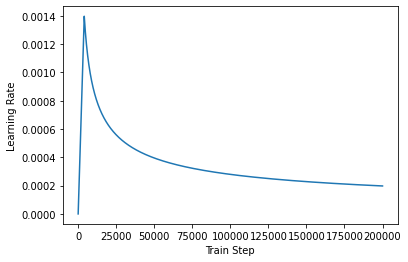

In [32]:
# train_step에 따라 학습률이 어떻게 변하는지 그래프로 확인
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [33]:
learning_rate = CustomSchedule(D_MODEL)

# 옵티마이저
optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# 성능 평가를 위한 정확도 함수
def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    # 두 문장의 유사도를 계산
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [34]:
# 모델 학습
EPOCHS = 10
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/10
185/185 [==============================] - 32s 53ms/step - loss: 1.4490 - accuracy: 0.0217
Epoch 2/10
185/185 [==============================] - 10s 53ms/step - loss: 1.1749 - accuracy: 0.0491
Epoch 3/10
185/185 [==============================] - 10s 53ms/step - loss: 1.0045 - accuracy: 0.0509
Epoch 4/10
185/185 [==============================] - 10s 53ms/step - loss: 0.9282 - accuracy: 0.0545
Epoch 5/10
185/185 [==============================] - 10s 53ms/step - loss: 0.8684 - accuracy: 0.0578
Epoch 6/10
185/185 [==============================] - 10s 54ms/step - loss: 0.8074 - accuracy: 0.0622
Epoch 7/10
185/185 [==============================] - 10s 54ms/step - loss: 0.7404 - accuracy: 0.0685
Epoch 8/10
185/185 [==============================] - 10s 54ms/step - loss: 0.6679 - accuracy: 0.0761
Epoch 9/10
185/185 [==============================] - 10s 54ms/step - loss: 0.5889 - accuracy: 0.0846
Epoch 10/10
185/185 [==============================] - 10s 54ms/step - loss: 0.507

# 6. 모델 평가하기

In [35]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [36]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [37]:
sentence_generation('나 지금 너무 피곤해.')

입력 : 나 지금 너무 피곤해.
출력 : 그 사람도 그 사람도 그럴 거예요 .


'그 사람도 그 사람도 그럴 거예요 .'

In [38]:
sentence_generation("너는 누구니?")

입력 : 너는 누구니?
출력 : 저는 위로봇입니다 .


'저는 위로봇입니다 .'